### Imports and set up

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
import itertools

#torch imports 
import torch
import torch.nn as nn
from torch.utils.data import DataLoader,TensorDataset
from torcheeg.io.eeg_signal import EEGSignalIO
from torcheeg.models import DGCNN
from sklearn.metrics import accuracy_score
from torcheeg.models.gnn.dgcnn import GraphConvolution
# helper sctipts 
import utils.graph_utils as gu
import utils.data_utils as du
import utils.model_utils as mu 
import utils.visual_utils as vu
from utils.model_utils import TrainNN
from utils.cka import CKACalculator

# tracking 
import wandb

## Path constants
path="artifacts"
modelname="dgcnn_mod"
data_path = "../data/"
preprocessed_data_path = f"{path}/preprocessed_data.npy"
has_val_set = False
seed = 42

## Establish connection to datafile
IO = EEGSignalIO(io_path=str(data_path), io_mode='lmdb')
bands = {"delta": [1, 4],"theta": [4, 8],"alpha": [8, 14],"beta": [14, 31],"gamma": [31, 49]}

## Read metadata dataframeimports
metadata = pd.read_csv(data_path + 'sample_metadata.tsv', sep='\t')

In [2]:
# Verifying connection to data
idxs = np.arange(len(metadata))

# Read features and labels as torch tensors
X = torch.FloatTensor(np.array([IO.read_eeg(str(i)) for i in idxs]))
y = torch.tensor(metadata["value"].values, dtype=torch.long)

In [3]:
X_bde = du.band_preprocess(X, preprocessed_data_path)     

### Split data into train, validation and test sets

In [5]:
if has_val_set:
    X_train, y_train, X_val, y_val, X_test, y_test = du.split_data(X_bde, y, has_val_set=has_val_set, seed=seed)
    assert (X_train.shape[0]+X_val.shape[0]+X_test.shape[0])==X.shape[0], "Data samples lost in preprossesing"
    assert (y_train.shape[0]+y_val.shape[0]+y_test.shape[0])==X.shape[0], "Data samples lost in preprossesing"
    
    nsamples_val, nchannels_val, bands = X_val.shape
    val_dataset = TensorDataset(X_val, y_val)
    val_loader = DataLoader(val_dataset, batch_size=64, shuffle=True)
    
else:
    X_train, y_train, X_test, y_test = du.split_data(X_bde, y, has_val_set=has_val_set, seed=seed)
    assert (X_train.shape[0]+X_test.shape[0])==X.shape[0], "Data samples lost in preprossesing"
    assert (y_train.shape[0]+y_test.shape[0])==X.shape[0], "Data samples lost in preprossesing"

assert X_train.shape[1]==X.shape[1],"Preprossed data lost channels"
assert X_train.shape[2]==len(bands),"Preprossed data does have incorrect amount of bands"

nsamples_train, nchannels_train, bands = X_train.shape
train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

TypeError: object of type 'int' has no len()

### Training & model hyperparameters

## Train model
### Train 4 models and calculate CKA matrices for pairs of models
## Functions to get activations of a layer type and calculated adjacency matrix

In [10]:
wandb.login()
def train_models(model,modeltrainer,hid_chans,seed_list, num_models=1,new =False, prints=False):
    """
    Training a model with random initialisation but consitent parameters. 
    
    Hyper parameters should be set outside of this function 
    
    path and model_names are both needed parameters that need to be defined outside of this function. 
    
    Path is to where your artifacts are located and model_name is what the model is called 
    
    ...
    
    Parameters
    -----------
    model : nn.modules
        The model being trained
    modeltrainer : training class
        a class for training the model provided should return a trained model
    num_models : int 
        Default 1, how many models it trains
    new : bool
        Weather it should attempt to use saved models
    """
    mods = []
    for i in range(num_models):
        
        tmp_mod = model(in_channels=num_chans, num_electrodes=num_electrodes, 
                              hid_channels=hid_chans, num_layers=num_layers, num_classes=num_outputs)
        model_path=f"{path}/{modelname}_chan{hid_chans}_{i}.pth"
        print(f"Model {i+1}")
        if new or not os.path.exists(model_path):    
            if not os.path.exists(model_path) and not new:
                print(f"Could not resolve path: {model_path}")
                new_models=True
            trainer = modeltrainer()
            
            if has_val_set:
                mods.append(trainer.train_model(tmp_mod, train_loader, learning_rate=lr,path=path,name=f"{modelname}_chan{hid_chans}",
                            has_val_set=has_val_set,val_loader=val_loader,w_decay=w_decay,epochs=epochs, 
                            prints=prints, modrun=i, seed=seed_list[i]))
            else:
                mods.append(trainer.train_model(tmp_mod, train_loader, learning_rate=lr,path=path,name=f"{modelname}_chan{hid_chans}",
                                                has_val_set=has_val_set,val_loader=None,w_decay=w_decay,epochs=epochs, 
                                                prints=prints, modrun=i, seed=seed_list[i]))   
        else: 
            tmp_mod.load_state_dict(torch.load(model_path))
            tmp_mod.eval()
            mods.append([tmp_mod,[]])
    return mods

In [12]:
# Model parameters
num_chans = 5
num_electrodes = 22
num_outputs = y.max().item() + 1
num_layers = 2
hid_chans = 16

# Training parameters
lr = 1e-4
epochs = 40
w_decay = 1e-3

seed_list = [42, 30, 66, 89]

#Models 
modruns = 4
plot=True
new_models=True
mods = train_models(DGCNN, TrainNN,hid_chans,seed_list, num_models=modruns, prints=plot, new=new_models)

Model 1


Epoch 1/40, Train loss: 1.5031, Train acc: 28.48
Epoch 2/40, Train loss: 1.3981, Train acc: 32.82
Epoch 3/40, Train loss: 1.3623, Train acc: 34.63
Epoch 4/40, Train loss: 1.3396, Train acc: 35.54
Epoch 5/40, Train loss: 1.3257, Train acc: 37.28
Epoch 6/40, Train loss: 1.3148, Train acc: 37.76
Epoch 7/40, Train loss: 1.3033, Train acc: 37.91
Epoch 8/40, Train loss: 1.2961, Train acc: 39.23
Epoch 9/40, Train loss: 1.2916, Train acc: 39.38
Epoch 10/40, Train loss: 1.2815, Train acc: 40.29
Epoch 11/40, Train loss: 1.2761, Train acc: 41.33
Epoch 12/40, Train loss: 1.2706, Train acc: 40.44
Epoch 13/40, Train loss: 1.2641, Train acc: 41.98
Epoch 14/40, Train loss: 1.2588, Train acc: 41.98
Epoch 15/40, Train loss: 1.2526, Train acc: 43.09
Epoch 16/40, Train loss: 1.2473, Train acc: 42.66
Epoch 17/40, Train loss: 1.2466, Train acc: 42.59
Epoch 18/40, Train loss: 1.2403, Train acc: 42.83
Epoch 19/40, Train loss: 1.2332, Train acc: 44.15
Epoch 20/40, Train loss: 1.2328, Train acc: 43.55
Epoch 21/

train accuracy,▁▃▃▄▄▄▄▅▅▅▆▅▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇█▇█▇███████
train_loss,█▆▅▅▄▄▄▄▄▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁
train accuracy,47.21485
train_loss,1.16271


Model 2


Epoch 1/40, Train loss: 1.5285, Train acc: 26.31
Epoch 2/40, Train loss: 1.3964, Train acc: 31.20
Epoch 3/40, Train loss: 1.3601, Train acc: 33.76
Epoch 4/40, Train loss: 1.3377, Train acc: 35.04
Epoch 5/40, Train loss: 1.3257, Train acc: 36.03
Epoch 6/40, Train loss: 1.3169, Train acc: 37.33
Epoch 7/40, Train loss: 1.3025, Train acc: 38.90
Epoch 8/40, Train loss: 1.2955, Train acc: 39.02
Epoch 9/40, Train loss: 1.2908, Train acc: 39.88
Epoch 10/40, Train loss: 1.2816, Train acc: 39.69
Epoch 11/40, Train loss: 1.2767, Train acc: 40.97
Epoch 12/40, Train loss: 1.2703, Train acc: 40.92
Epoch 13/40, Train loss: 1.2620, Train acc: 41.62
Epoch 14/40, Train loss: 1.2570, Train acc: 41.89
Epoch 15/40, Train loss: 1.2512, Train acc: 42.61
Epoch 16/40, Train loss: 1.2465, Train acc: 43.16
Epoch 17/40, Train loss: 1.2446, Train acc: 42.63
Epoch 18/40, Train loss: 1.2356, Train acc: 43.55
Epoch 19/40, Train loss: 1.2321, Train acc: 44.61
Epoch 20/40, Train loss: 1.2251, Train acc: 44.51
Epoch 21/

train accuracy,▁▃▃▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇█████████
train_loss,█▆▅▄▄▄▄▄▄▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
train accuracy,48.73402
train_loss,1.15668


Model 3


Epoch 1/40, Train loss: 1.5109, Train acc: 29.01
Epoch 2/40, Train loss: 1.3947, Train acc: 33.57
Epoch 3/40, Train loss: 1.3657, Train acc: 34.68
Epoch 4/40, Train loss: 1.3461, Train acc: 35.83
Epoch 5/40, Train loss: 1.3307, Train acc: 36.12
Epoch 6/40, Train loss: 1.3214, Train acc: 37.57
Epoch 7/40, Train loss: 1.3097, Train acc: 37.88
Epoch 8/40, Train loss: 1.2977, Train acc: 39.23
Epoch 9/40, Train loss: 1.2959, Train acc: 39.33
Epoch 10/40, Train loss: 1.2855, Train acc: 39.84
Epoch 11/40, Train loss: 1.2807, Train acc: 40.32
Epoch 12/40, Train loss: 1.2713, Train acc: 41.40
Epoch 13/40, Train loss: 1.2704, Train acc: 41.64
Epoch 14/40, Train loss: 1.2615, Train acc: 41.74
Epoch 15/40, Train loss: 1.2551, Train acc: 42.97
Epoch 16/40, Train loss: 1.2528, Train acc: 41.89
Epoch 17/40, Train loss: 1.2433, Train acc: 43.38
Epoch 18/40, Train loss: 1.2430, Train acc: 43.96
Epoch 19/40, Train loss: 1.2341, Train acc: 43.60
Epoch 20/40, Train loss: 1.2297, Train acc: 44.18
Epoch 21/

train accuracy,▁▃▃▃▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇███████
train_loss,█▆▅▅▄▄▄▄▄▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁
train accuracy,48.63757
train_loss,1.16264


Model 4


Epoch 1/40, Train loss: 1.5601, Train acc: 29.54
Epoch 2/40, Train loss: 1.4100, Train acc: 33.35
Epoch 3/40, Train loss: 1.3623, Train acc: 35.28
Epoch 4/40, Train loss: 1.3329, Train acc: 37.18
Epoch 5/40, Train loss: 1.3161, Train acc: 37.26
Epoch 6/40, Train loss: 1.3025, Train acc: 39.64
Epoch 7/40, Train loss: 1.2899, Train acc: 39.23
Epoch 8/40, Train loss: 1.2833, Train acc: 40.56
Epoch 9/40, Train loss: 1.2708, Train acc: 41.04
Epoch 10/40, Train loss: 1.2631, Train acc: 41.52
Epoch 11/40, Train loss: 1.2562, Train acc: 42.25
Epoch 12/40, Train loss: 1.2459, Train acc: 42.83
Epoch 13/40, Train loss: 1.2441, Train acc: 43.43
Epoch 14/40, Train loss: 1.2381, Train acc: 43.04
Epoch 15/40, Train loss: 1.2301, Train acc: 43.72
Epoch 16/40, Train loss: 1.2243, Train acc: 44.13
Epoch 17/40, Train loss: 1.2204, Train acc: 44.10
Epoch 18/40, Train loss: 1.2124, Train acc: 44.66
Epoch 19/40, Train loss: 1.2111, Train acc: 44.61
Epoch 20/40, Train loss: 1.2055, Train acc: 45.12
Epoch 21/

train accuracy,▁▂▃▄▄▅▄▅▅▅▅▆▆▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇██████
train_loss,█▆▅▄▄▄▄▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
train accuracy,49.26453
train_loss,1.13373


In [ ]:
def lst_to_dict(lst):
    return dict([(x, []) for x in lst])
def internal_dict(lst):
    models_dict     = lst_to_dict(lst)  #Dict with all models
    bary_dict       = lst_to_dict(lst)  #Graph metric dict n for barycenter
    sim_dict        = lst_to_dict(lst)  #Graph metric dict n for simrank
    edit_dists      = lst_to_dict(lst)  #Graph metric dict n for GED between similar param models
    return models_dict,bary_dict,sim_dict,edit_dists

def multi_parameter_mod(param_list, seed_list, n_models):
    # TO DO: take into account seeds. Right now the seed_list doesn't do anything
    # all combinations of model indexes between two parameter sets
    # ex all model combinations between models with 8 hidden neurons and models with 16 hidden neurons
    combs_external =[
        (i, j)
        for i in range(n_models)
        for j in range(n_models, 2 * n_models)
        ]
    #combs_external = list(itertools.product([x for x in range(n_models)], [x+n_models for x in range(n_models)]))
    # all combinations of parameter values, in this case number of hidden neurons
    param_combs = [
        (param_list[i], param_list[j]) 
        for i in range(0,   len(param_list)) 
        for j in range(i+1, len(param_list))]
    
    models_dict, bary_dict, sim_dict, edit_dists_internal = internal_dict(param_list)
    edit_dists_external = lst_to_dict(param_combs)   #Graph metric dict n for GED between different param models
    
    # train n_models models with each number of hidden neurons specified in the param_list
    for n_chans in param_list:
        curr_model = [x[0] for x in train_models(DGCNN, TrainNN, n_chans, num_models = n_models, prints=plot, new=False)]
        models_dict[n_chans].extend(curr_model)
    
    # calculate all metrics for models with the same number of hidden neurons
    for n_chans in param_list:
        models = models_dict[n_chans]
        bary, sim, _, ed = gu.get_graph_metrics(models, prints=False)
        bary_dict[n_chans].extend(bary)
        sim_dict[n_chans].extend(sim)
        edit_dists_internal[n_chans].extend(ed)
    
    # calculate edit distance between models with different number of hidden neurons
    for param_comb in param_combs:
        for ext_comb in combs_external:
            model1_idx = ext_comb[0]; model2_idx = ext_comb[1]
            model1 = models_dict[param_comb[0]][model1_idx]
            model2 = models_dict[param_comb[1]][model2_idx-n_models]
            G1 = gu.make_graph(mu.get_adj_mat(model1))
            G2 = gu.make_graph(mu.get_adj_mat(model2))
            ed_external = next(nx.optimize_graph_edit_distance(G1, G2))
            edit_dists_external[param_comb].append(ed_external)

    return models_dict, bary_dict, sim_dict, edit_dists_internal, edit_dists_external

In [8]:
param_list = [8, 16, 24]
seed_list = [42]
n_models = 4

models, barycenters, sims, edit_dists_internal, edit_dists_external = multi_parameter_mod(param_list, seed_list, n_models)

Model 1
Model 2
Could not resolve path: artifacts/dgcnn_mod_chan8_1.pth


Epoch 1/40, Train loss: 1.6400, Train acc: 23.78
Epoch 2/40, Train loss: 1.4742, Train acc: 27.32
Epoch 3/40, Train loss: 1.4241, Train acc: 29.11
Epoch 4/40, Train loss: 1.3994, Train acc: 30.72
Epoch 5/40, Train loss: 1.3834, Train acc: 31.78
Epoch 6/40, Train loss: 1.3684, Train acc: 33.04
Epoch 7/40, Train loss: 1.3573, Train acc: 34.05
Epoch 8/40, Train loss: 1.3487, Train acc: 34.12
Epoch 9/40, Train loss: 1.3393, Train acc: 35.06
Epoch 10/40, Train loss: 1.3326, Train acc: 36.05
Epoch 11/40, Train loss: 1.3233, Train acc: 36.80
Epoch 12/40, Train loss: 1.3181, Train acc: 37.67
Epoch 13/40, Train loss: 1.3118, Train acc: 37.76
Epoch 14/40, Train loss: 1.3075, Train acc: 38.15
Epoch 15/40, Train loss: 1.3022, Train acc: 39.04
Epoch 16/40, Train loss: 1.2989, Train acc: 39.55
Epoch 17/40, Train loss: 1.2945, Train acc: 39.81
Epoch 18/40, Train loss: 1.2903, Train acc: 40.22
Epoch 19/40, Train loss: 1.2854, Train acc: 40.49
Epoch 20/40, Train loss: 1.2841, Train acc: 40.82
Epoch 21/

train accuracy,▁▂▃▃▄▄▄▄▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇█████████
train_loss,█▅▄▄▄▄▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁
train accuracy,44.70702
train_loss,1.21167


Model 3
Could not resolve path: artifacts/dgcnn_mod_chan8_2.pth


Epoch 1/40, Train loss: 1.7347, Train acc: 19.94
Epoch 2/40, Train loss: 1.5184, Train acc: 27.56
Epoch 3/40, Train loss: 1.4371, Train acc: 30.62
Epoch 4/40, Train loss: 1.3962, Train acc: 32.94
Epoch 5/40, Train loss: 1.3740, Train acc: 34.02
Epoch 6/40, Train loss: 1.3598, Train acc: 34.39
Epoch 7/40, Train loss: 1.3453, Train acc: 35.66
Epoch 8/40, Train loss: 1.3384, Train acc: 35.93
Epoch 9/40, Train loss: 1.3304, Train acc: 36.22
Epoch 10/40, Train loss: 1.3227, Train acc: 35.88
Epoch 11/40, Train loss: 1.3144, Train acc: 36.68
Epoch 12/40, Train loss: 1.3085, Train acc: 37.23
Epoch 13/40, Train loss: 1.3048, Train acc: 37.21
Epoch 14/40, Train loss: 1.2984, Train acc: 37.91
Epoch 15/40, Train loss: 1.2919, Train acc: 39.21
Epoch 16/40, Train loss: 1.2898, Train acc: 39.43
Epoch 17/40, Train loss: 1.2868, Train acc: 39.31
Epoch 18/40, Train loss: 1.2801, Train acc: 38.65
Epoch 19/40, Train loss: 1.2768, Train acc: 40.39
Epoch 20/40, Train loss: 1.2724, Train acc: 40.32
Epoch 21/

train accuracy,▁▃▄▄▅▅▅▅▅▅▅▆▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇███████
train_loss,█▅▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
train accuracy,46.0815
train_loss,1.205


Model 4
Could not resolve path: artifacts/dgcnn_mod_chan8_3.pth


Epoch 1/40, Train loss: 2.0216, Train acc: 24.62
Epoch 2/40, Train loss: 1.5285, Train acc: 27.27
Epoch 3/40, Train loss: 1.4432, Train acc: 28.04
Epoch 4/40, Train loss: 1.4177, Train acc: 29.71
Epoch 5/40, Train loss: 1.4003, Train acc: 30.02
Epoch 6/40, Train loss: 1.3863, Train acc: 31.16
Epoch 7/40, Train loss: 1.3768, Train acc: 32.24
Epoch 8/40, Train loss: 1.3654, Train acc: 33.04
Epoch 9/40, Train loss: 1.3559, Train acc: 33.47
Epoch 10/40, Train loss: 1.3483, Train acc: 34.58
Epoch 11/40, Train loss: 1.3424, Train acc: 35.04
Epoch 12/40, Train loss: 1.3316, Train acc: 35.74
Epoch 13/40, Train loss: 1.3299, Train acc: 36.58
Epoch 14/40, Train loss: 1.3205, Train acc: 37.26
Epoch 15/40, Train loss: 1.3166, Train acc: 36.82
Epoch 16/40, Train loss: 1.3129, Train acc: 36.97
Epoch 17/40, Train loss: 1.3092, Train acc: 37.28
Epoch 18/40, Train loss: 1.3022, Train acc: 38.12
Epoch 19/40, Train loss: 1.2980, Train acc: 38.82
Epoch 20/40, Train loss: 1.2918, Train acc: 39.50
Epoch 21/

train accuracy,▁▂▂▃▃▃▄▄▄▅▅▅▅▆▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇████████
train_loss,█▄▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train accuracy,44.03183
train_loss,1.22253


Model 1
Model 2
Model 3
Model 4
Model 1
Model 2
Could not resolve path: artifacts/dgcnn_mod_chan24_1.pth


Epoch 1/40, Train loss: 1.5812, Train acc: 27.95
Epoch 2/40, Train loss: 1.4118, Train acc: 33.90
Epoch 3/40, Train loss: 1.3637, Train acc: 35.95
Epoch 4/40, Train loss: 1.3383, Train acc: 36.75
Epoch 5/40, Train loss: 1.3181, Train acc: 37.98
Epoch 6/40, Train loss: 1.3035, Train acc: 38.90
Epoch 7/40, Train loss: 1.2938, Train acc: 39.52
Epoch 8/40, Train loss: 1.2795, Train acc: 41.04
Epoch 9/40, Train loss: 1.2713, Train acc: 41.09
Epoch 10/40, Train loss: 1.2606, Train acc: 41.81
Epoch 11/40, Train loss: 1.2548, Train acc: 42.95
Epoch 12/40, Train loss: 1.2492, Train acc: 42.99
Epoch 13/40, Train loss: 1.2425, Train acc: 43.12
Epoch 14/40, Train loss: 1.2347, Train acc: 43.79
Epoch 15/40, Train loss: 1.2275, Train acc: 44.08
Epoch 16/40, Train loss: 1.2191, Train acc: 45.41
Epoch 17/40, Train loss: 1.2101, Train acc: 45.48
Epoch 18/40, Train loss: 1.2076, Train acc: 45.82
Epoch 19/40, Train loss: 1.2022, Train acc: 46.20
Epoch 20/40, Train loss: 1.1987, Train acc: 46.03
Epoch 21/

train accuracy,▁▃▃▄▄▄▄▅▅▅▆▆▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇█▇▇▇███████
train_loss,█▅▅▄▄▄▄▄▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
train accuracy,50.88015
train_loss,1.10733


Model 3
Could not resolve path: artifacts/dgcnn_mod_chan24_2.pth


Epoch 1/40, Train loss: 1.5563, Train acc: 26.60
Epoch 2/40, Train loss: 1.3922, Train acc: 32.60
Epoch 3/40, Train loss: 1.3542, Train acc: 35.18
Epoch 4/40, Train loss: 1.3323, Train acc: 36.92
Epoch 5/40, Train loss: 1.3164, Train acc: 37.88
Epoch 6/40, Train loss: 1.3059, Train acc: 38.51
Epoch 7/40, Train loss: 1.2949, Train acc: 39.16
Epoch 8/40, Train loss: 1.2842, Train acc: 40.66
Epoch 9/40, Train loss: 1.2767, Train acc: 40.49
Epoch 10/40, Train loss: 1.2705, Train acc: 40.73
Epoch 11/40, Train loss: 1.2614, Train acc: 41.14
Epoch 12/40, Train loss: 1.2548, Train acc: 41.96
Epoch 13/40, Train loss: 1.2523, Train acc: 42.39
Epoch 14/40, Train loss: 1.2435, Train acc: 42.63
Epoch 15/40, Train loss: 1.2405, Train acc: 42.68
Epoch 16/40, Train loss: 1.2332, Train acc: 43.26
Epoch 17/40, Train loss: 1.2308, Train acc: 43.86
Epoch 18/40, Train loss: 1.2239, Train acc: 44.18
Epoch 19/40, Train loss: 1.2172, Train acc: 44.80
Epoch 20/40, Train loss: 1.2094, Train acc: 45.53
Epoch 21/

train accuracy,▁▃▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇██████
train_loss,█▅▅▄▄▄▄▄▃▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁
train accuracy,50.18085
train_loss,1.132


Model 4
Could not resolve path: artifacts/dgcnn_mod_chan24_3.pth


Epoch 1/40, Train loss: 1.5863, Train acc: 23.13
Epoch 2/40, Train loss: 1.4097, Train acc: 32.38
Epoch 3/40, Train loss: 1.3614, Train acc: 35.01
Epoch 4/40, Train loss: 1.3367, Train acc: 36.29
Epoch 5/40, Train loss: 1.3172, Train acc: 38.56
Epoch 6/40, Train loss: 1.3049, Train acc: 39.06
Epoch 7/40, Train loss: 1.2922, Train acc: 39.72
Epoch 8/40, Train loss: 1.2842, Train acc: 40.61
Epoch 9/40, Train loss: 1.2746, Train acc: 41.07
Epoch 10/40, Train loss: 1.2647, Train acc: 41.62
Epoch 11/40, Train loss: 1.2581, Train acc: 42.08
Epoch 12/40, Train loss: 1.2512, Train acc: 42.44
Epoch 13/40, Train loss: 1.2445, Train acc: 42.56
Epoch 14/40, Train loss: 1.2391, Train acc: 43.69
Epoch 15/40, Train loss: 1.2309, Train acc: 43.28
Epoch 16/40, Train loss: 1.2271, Train acc: 44.61
Epoch 17/40, Train loss: 1.2206, Train acc: 44.13
Epoch 18/40, Train loss: 1.2147, Train acc: 45.50
Epoch 19/40, Train loss: 1.2095, Train acc: 45.60
Epoch 20/40, Train loss: 1.2054, Train acc: 45.21
Epoch 21/

train accuracy,▁▃▄▄▅▅▅▅▆▆▆▆▆▆▆▇▆▇▇▇▇▇▇▇▇▇▇▇████████████
train_loss,█▅▅▄▄▄▄▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
train accuracy,50.37376
train_loss,1.12737


Model 1 test
Acc train: 0.4805883771401013
Acc test: 0.4513018322082932
F1 train: 0.474830896700154
F1 test: 0.4460914353194284


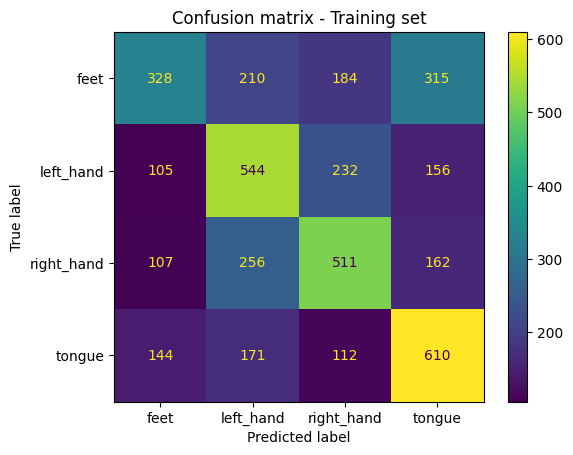

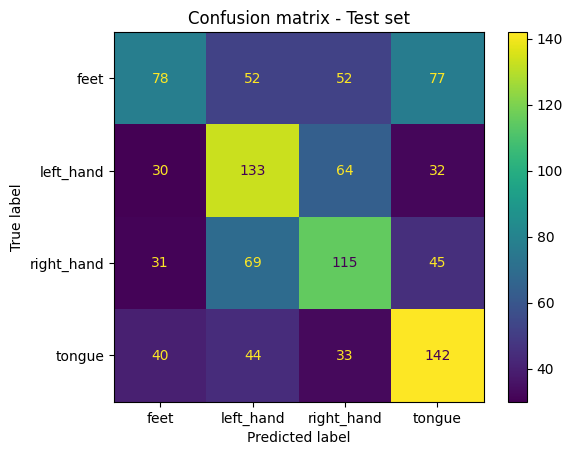

Model 2 test
Acc train: 0.4928864239209067
Acc test: 0.45805207328833175
F1 train: 0.4897161907701396
F1 test: 0.45453073948441514


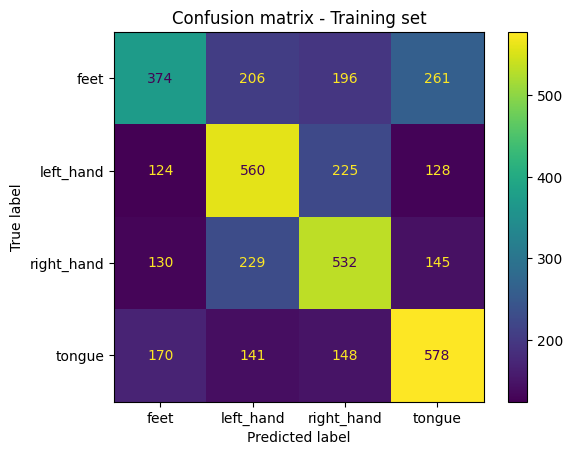

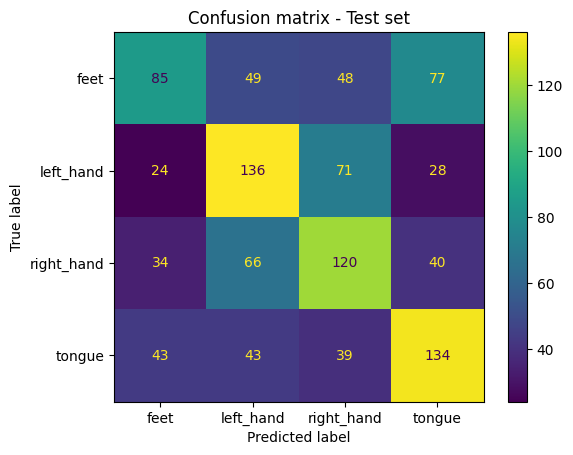

Model 3 test
Acc train: 0.5022908126356402
Acc test: 0.43683702989392476
F1 train: 0.4997001144161498
F1 test: 0.43398668978200516


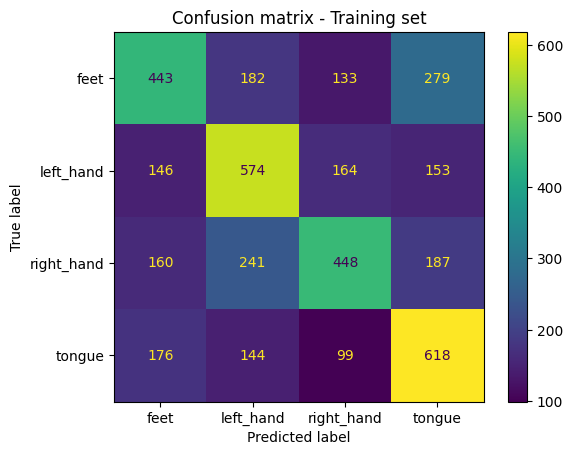

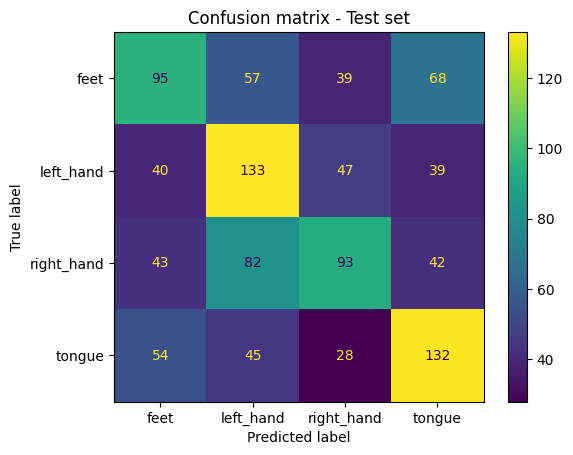

Model 4 test
Acc train: 0.5097660959729925
Acc test: 0.43105110896817744
F1 train: 0.5081712623509012
F1 test: 0.4287606939852392


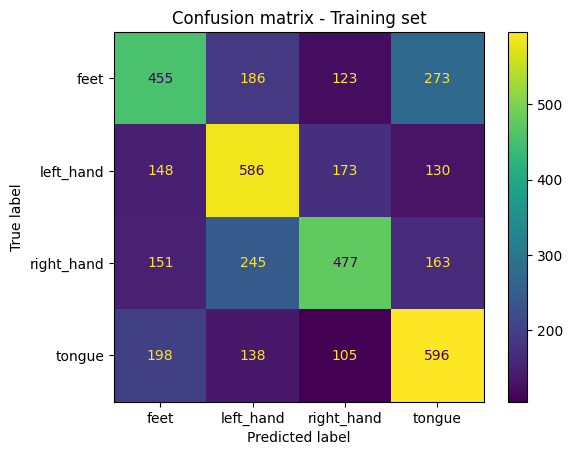

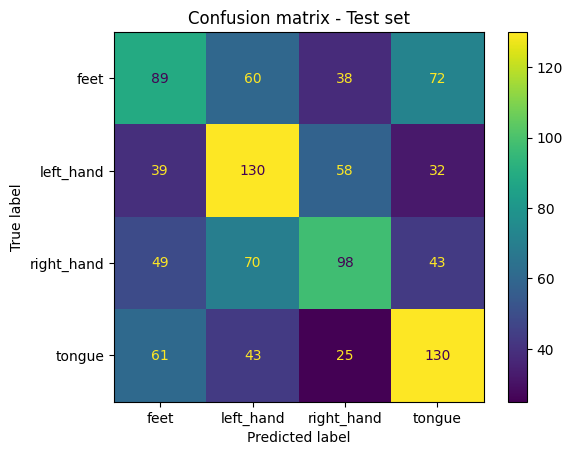

In [13]:
for i in range(modruns):
    print(f"Model {i+1} test")
    test_model = mods[i][0].to("cpu").eval()
    mu.model_metrics(test_model, X_train, y_train, X_test, y_test, None, None,plots=plot)

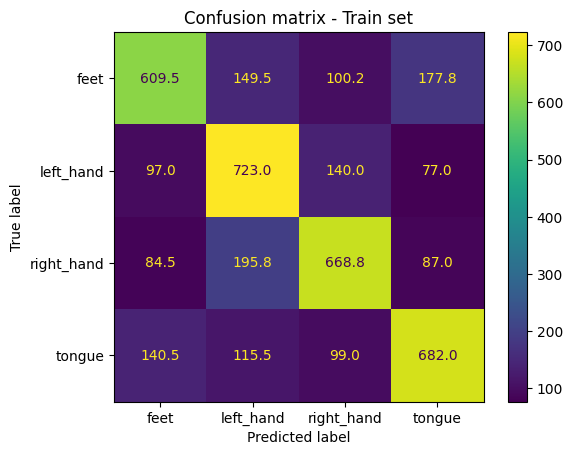

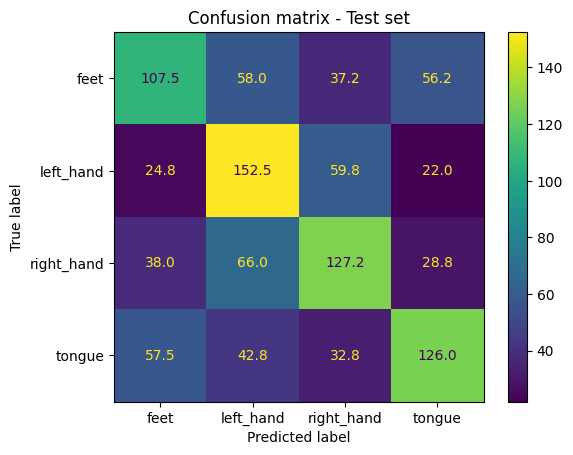

(array([[609.5 , 149.5 , 100.25, 177.75],
        [ 97.  , 723.  , 140.  ,  77.  ],
        [ 84.5 , 195.75, 668.75,  87.  ],
        [140.5 , 115.5 ,  99.  , 682.  ]]),
 array([[107.5 ,  58.  ,  37.25,  56.25],
        [ 24.75, 152.5 ,  59.75,  22.  ],
        [ 38.  ,  66.  , 127.25,  28.75],
        [ 57.5 ,  42.75,  32.75, 126.  ]]))

In [10]:
mu.confusiong_avg(mods,X_train, y_train, X_test, y_test,plots=True)

## Graphs


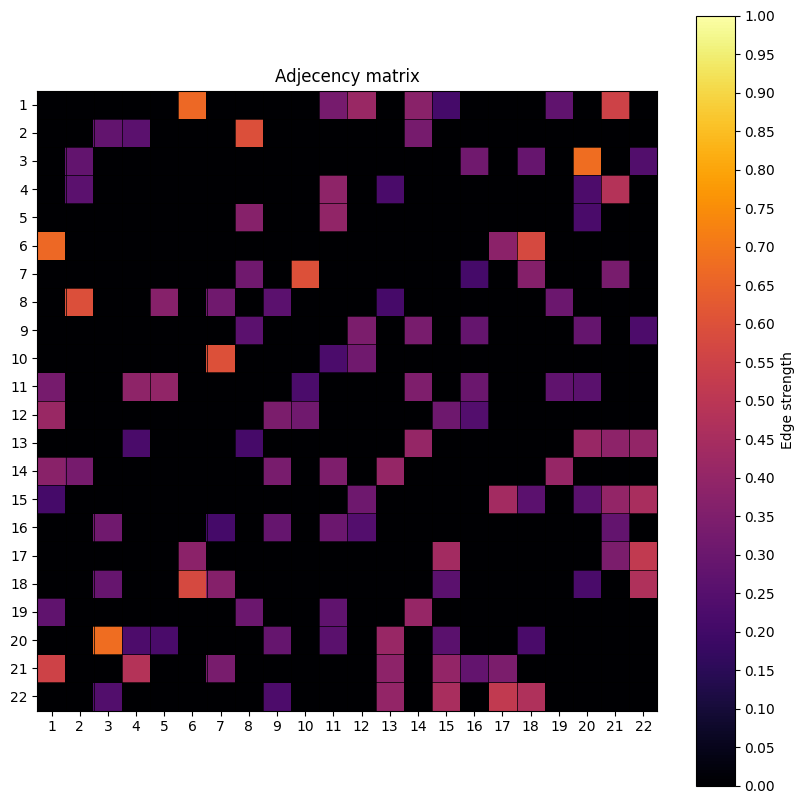

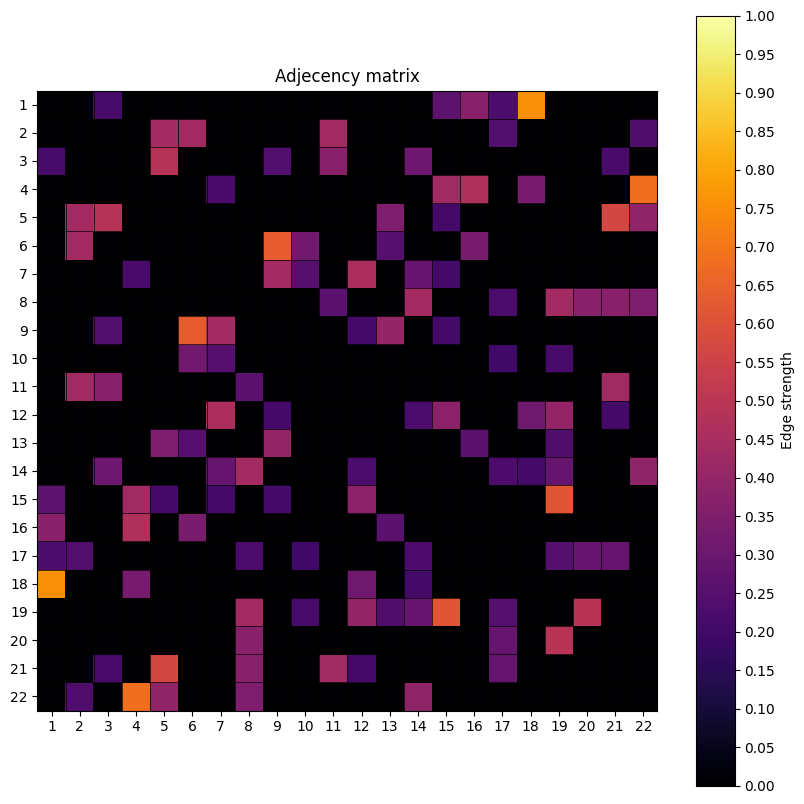

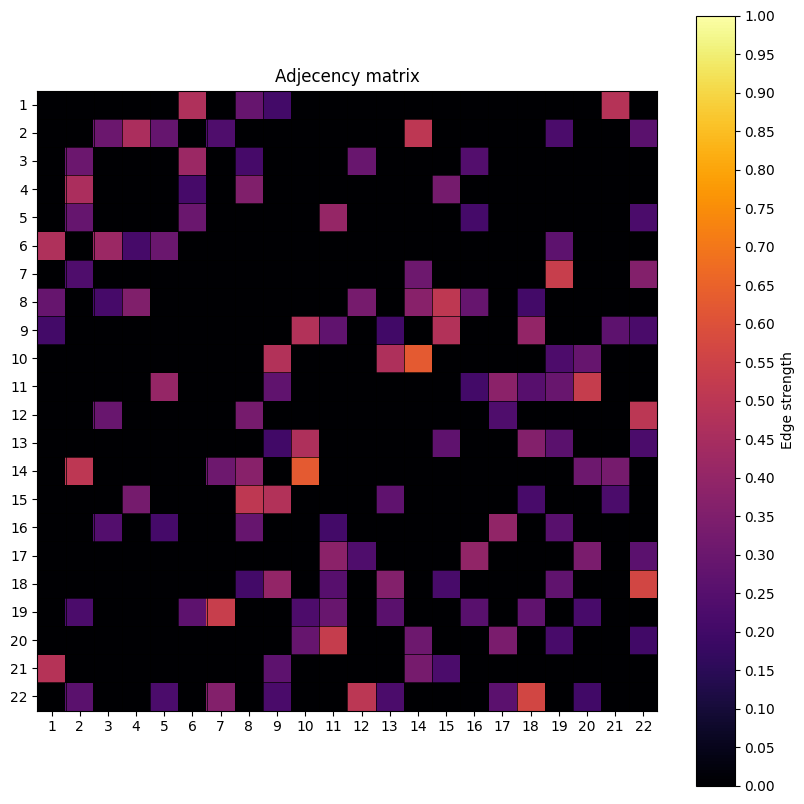

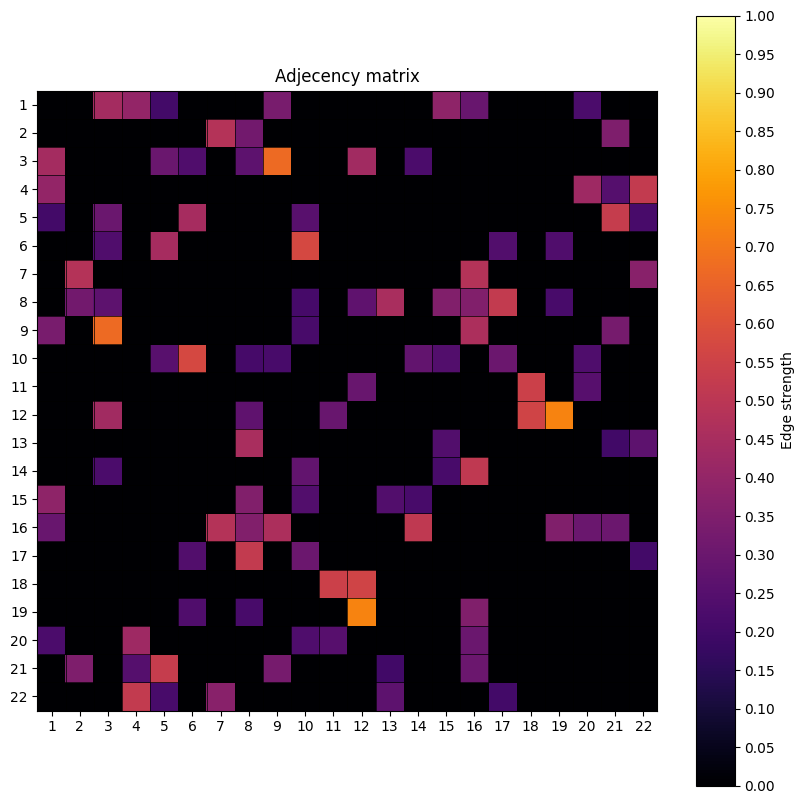

In [11]:
graphs=[]
adj_mats=[]
for i in range(modruns):
    adj_mats.append(mu.get_adj_mat(mods[i][0]))
    graphs.append(gu.make_graph(adj_mats[i]))
if plot:
    for adj in adj_mats:
        vu.visualize_adj_mat(adj)
#throw error if isomophic
for G1 in range(len(mods)):
    for G2 in range(G1+1,len(mods)):
        assert gu.check_not_isomorphism(graphs[G1],graphs[G2]), f"Graph G{G1} and G{G2} are isomophic"

In [12]:
if plot:
    vu.graph_plot(adj_mats,vu.graph_visual,2,2, barycenters)

KeyError: 0

<Figure size 1000x1000 with 0 Axes>

In [ ]:
bi_g, bi_adj = gu.make_binary_graph(adj_mats[2],thresh=0.3)
if plot:
    vu.visualize_adj_mat(bi_adj)
    vu.graph_plot([bi_adj],vu.graph_visual,1,1,barycenters)

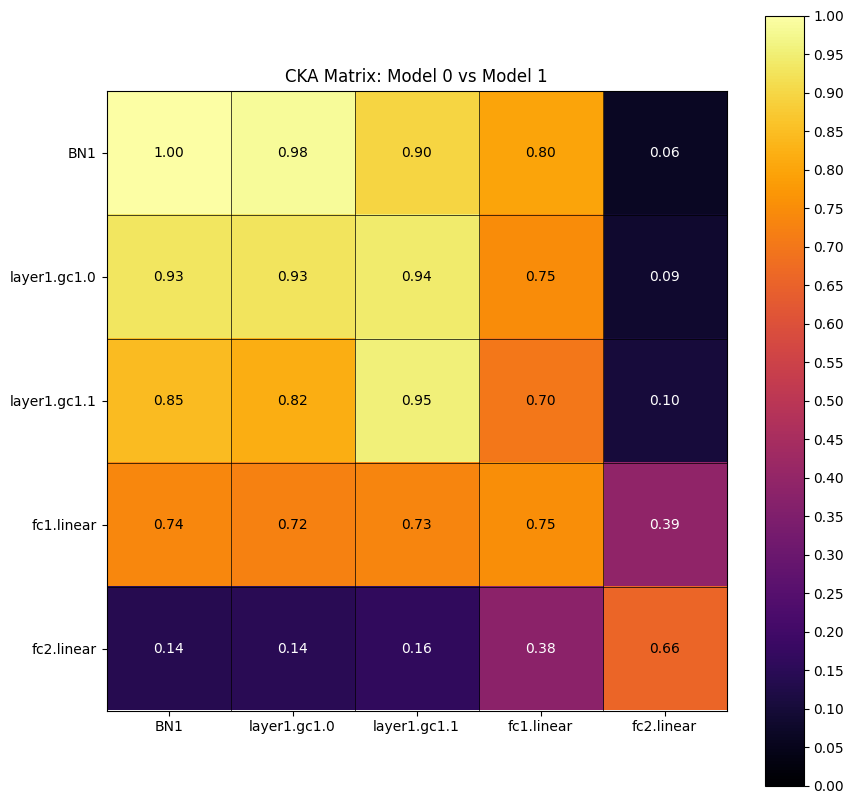

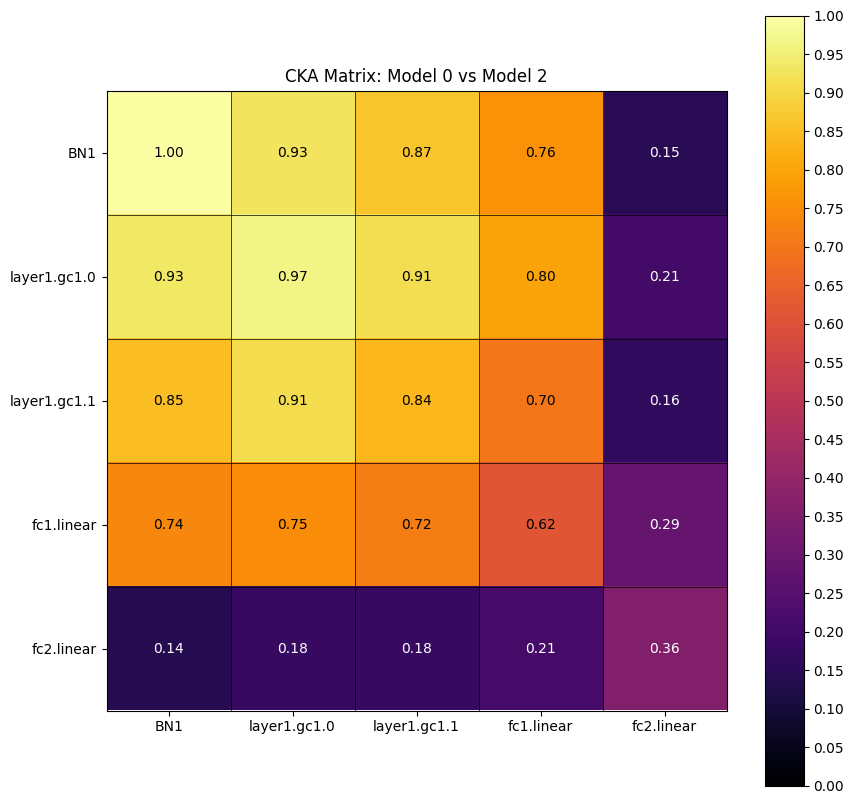

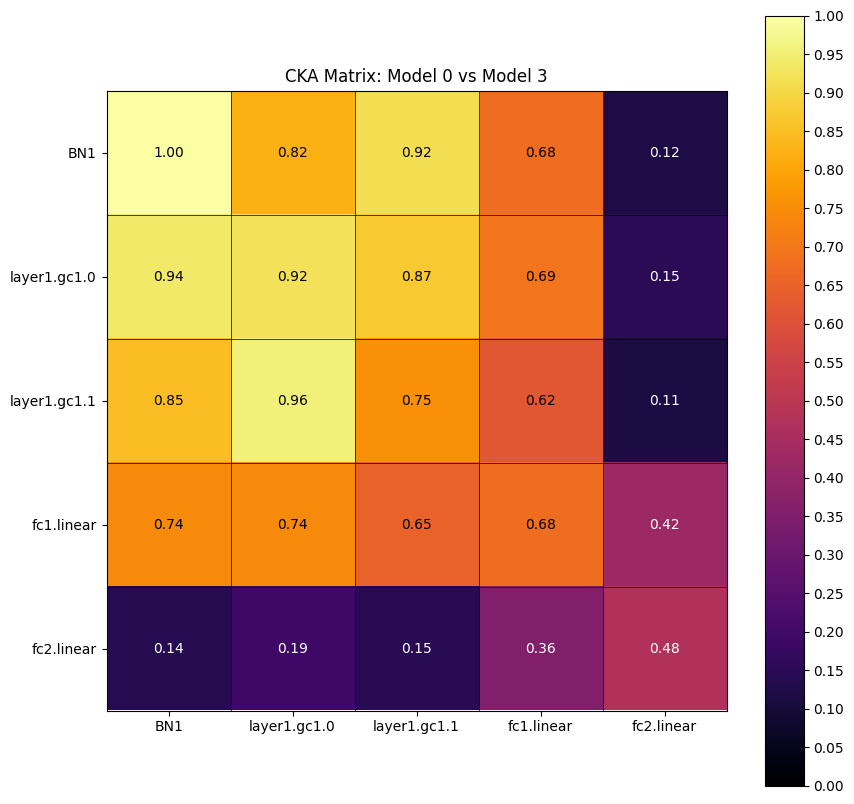

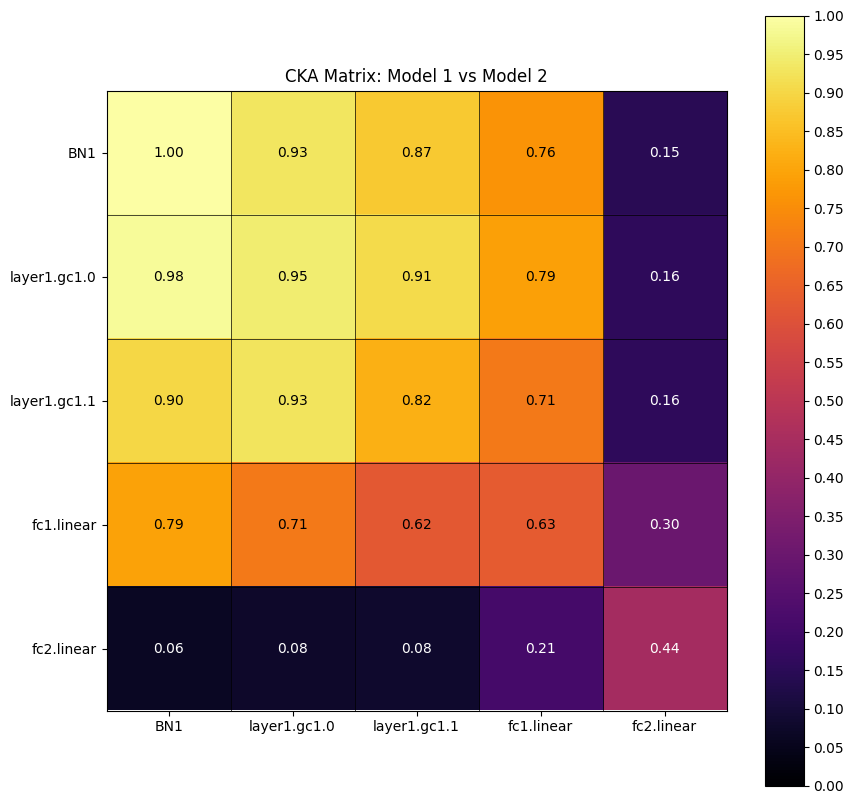

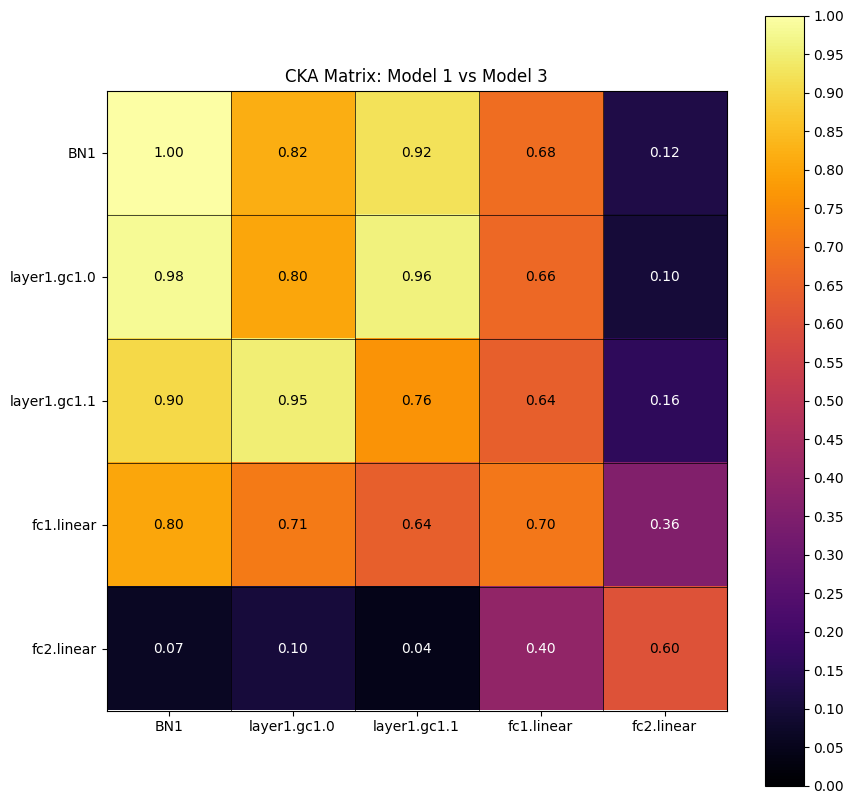

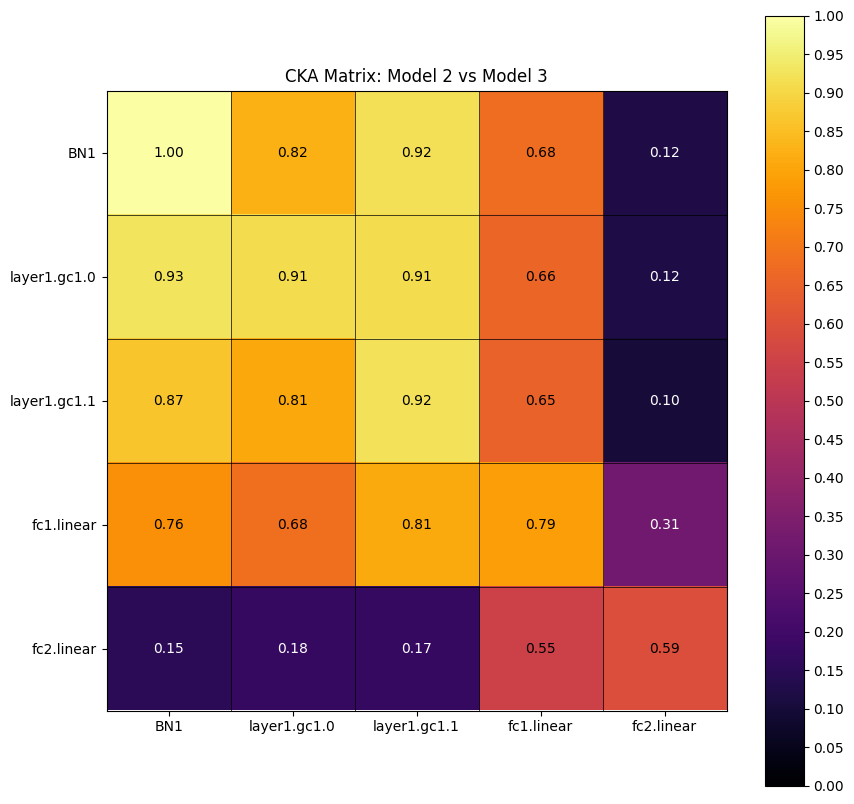

In [ ]:
cka_all = []
for i in range(modruns-1):
    for j in range(i+1,modruns):
        calculator = CKACalculator(model1=mods[i][0], model2=mods[j][0], 
                                dataloader=train_loader,
                                layers_to_hook=(nn.Conv2d, nn.Linear,
                                     nn.AdaptiveAvgPool2d, GraphConvolution, nn.BatchNorm1d))
        cka_output = calculator.calculate_cka_matrix(train_dataset)
        #calculator.test_cka(10,train_dataset)
        cka_all.append(cka_output)
        if plot:
            vu.plot_matrix(f'CKA Matrix: Model {i} vs Model {j}'
                          ,cka_output.cpu().numpy(),calculator.module_names_X,
                           calculator.module_names_Y)

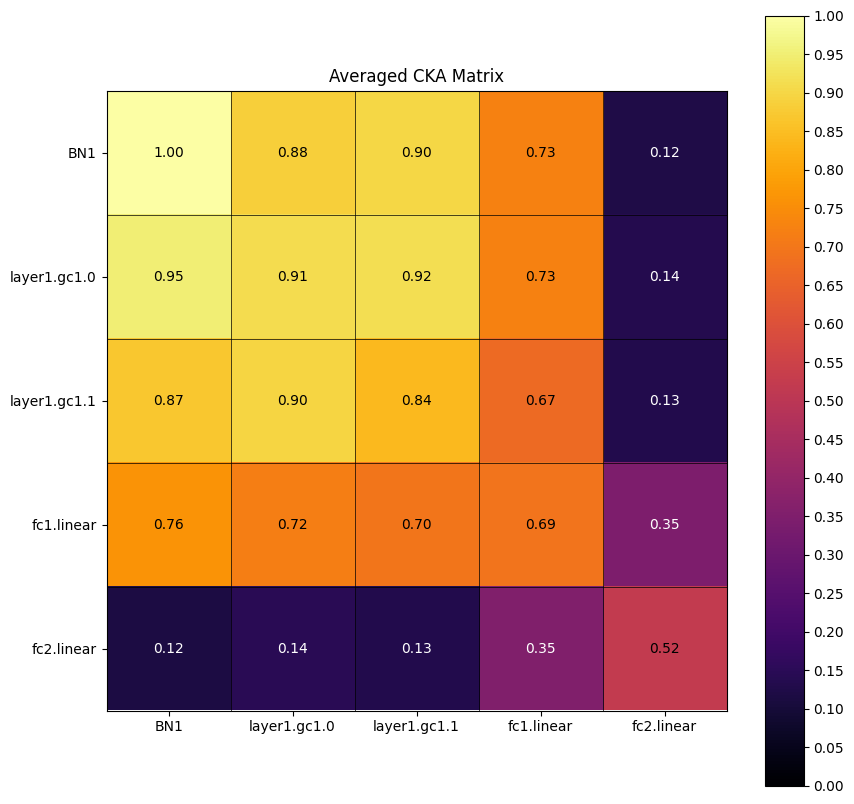

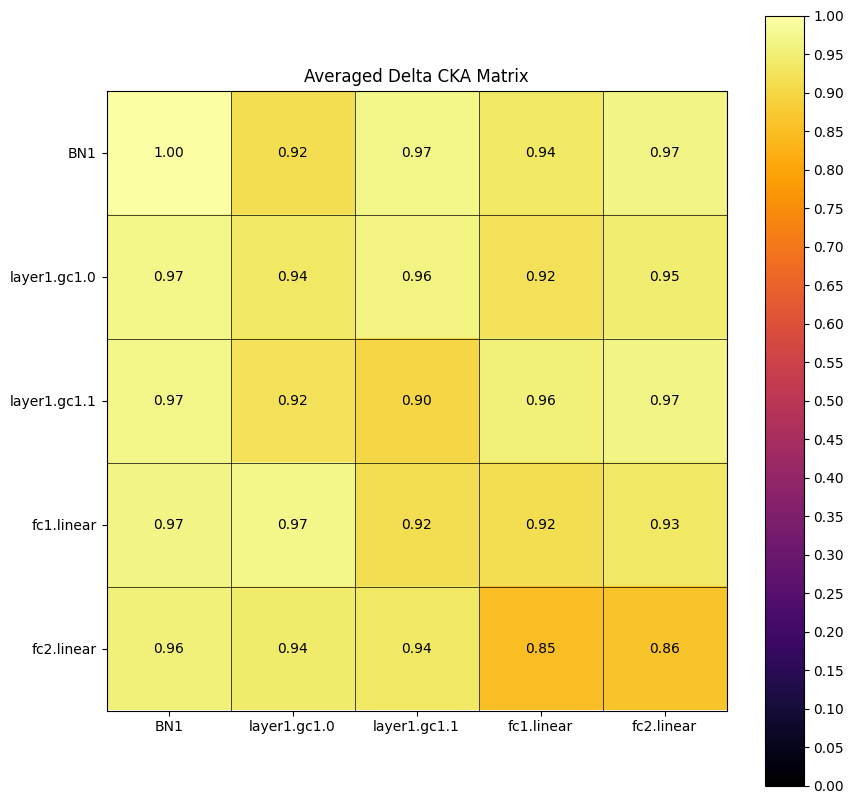

In [ ]:
cka_stack = torch.stack(cka_all) 
average_cka_matrix = cka_stack.mean(dim=0)
delta_matrices = []

for i in range(len(cka_stack)):
    for j in range(i+1,len(cka_stack)):
        delta_matrices.append(torch.abs(cka_stack[i] - cka_stack[j])) 
        
delta_matrices = torch.stack(delta_matrices)  
average_delta_cka_matrix = 1- delta_matrices.mean(dim=0)  
if plot:
    vu.plot_matrix("Averaged CKA Matrix",average_cka_matrix.cpu().numpy(),calculator.module_names_X,calculator.module_names_Y)
    vu.plot_matrix("Averaged Delta CKA Matrix",average_delta_cka_matrix.cpu().numpy(),calculator.module_names_X,calculator.module_names_Y)

In [ ]:
if has_val_set:

    for i  in range (len(mods)):
        filepath=f"{path}/Training_validation_loss{i}.npy"
        if not new_models:
            try: 
                with open(filepath, "rb") as f:
                    data = np.load(f)
            except:
                print(f"File with the data could not be found looking at address: {filepath}")
        else:
            with open(filepath, "wb") as f:
                np.save(f, mods[0][1])
                data = mods[0][1]
        plt.plot(data[0])
        plt.plot(data[1])
        plt.xlabel("Epochs")
        plt.ylabel("Loss")
        plt.legend(["training loss","validation loss"])
        plt.title(f"Model{i} Training vs validation loss")
        plt.show()
    